
# Part 2 — Vision Transformer (ViT) for Chest X‑ray Classification

**Dataset choice:** Option 2 — Chest X-ray Pneumonia (pre-split into `train/`, `val/`, `test/`).  
**Goal:** Fine-tune a ViT model to classify chest X-rays as **PNEUMONIA** vs **NORMAL** and report metrics & insights.

> This notebook follows the project instructions and the ViT paper (Dosovitskiy et al., 2020, *"An Image is Worth 16x16 Words"*).


## 1) Setup & Reproducibility

In [4]:

import os
import random
import time
import math
from pathlib import Path

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Optional: metrics & plots
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

## 2) Data: paths, transforms, and loaders

In [5]:
## אופציה א': שימוש ב-kagglehub (כמו בדוגמה שנתתם)
try:
    import kagglehub
    path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
    base_dir = os.path.join(path, "chest_xray")
except Exception as e:
    print('kagglehub לא זמין/נכשל, עוברים לאופציה ב\'')
    base_dir = "/path/to/your/chest_xray"  # עדכנו ידנית אם צריך

train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')
print('Base dir:', base_dir)

## קונפיג תמונה
IMG_SIZE = 224  # ViT בדרך כלל מאומן/מותאם סביב 224/256/384

## Augmentations "עדינות" שמתאימות לרדיולוגיה (לא להפוך אופקי/אנכי דרסטי)
train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # הפיכת חד-ערוצי ל-RGB 3 ערוצים
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.05,0.05))], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),  # טווח [-1,1]
])

eval_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=eval_tfms)

print('Classes:', train_ds.classes)
NUM_CLASSES = len(train_ds.classes)

train_dir = os.path.join(base_dir, 'train') if base_dir else None
val_dir   = os.path.join(base_dir, 'val') if base_dir else None
test_dir  = os.path.join(base_dir, 'test') if base_dir else None

print("Base dir:", base_dir)
print("train_dir:", train_dir)
print("val_dir:", val_dir)
print("test_dir:", test_dir)


Base dir: /kaggle/input/chest-xray-pneumonia/chest_xray
Classes: ['NORMAL', 'PNEUMONIA']
Base dir: /kaggle/input/chest-xray-pneumonia/chest_xray
train_dir: /kaggle/input/chest-xray-pneumonia/chest_xray/train
val_dir: /kaggle/input/chest-xray-pneumonia/chest_xray/val
test_dir: /kaggle/input/chest-xray-pneumonia/chest_xray/test


In [6]:

# Transforms
# Notes:
# - Chest X-rays are grayscale; ViT expects 3 channels (ImageNet). We convert to 3 channels.
# - Horizontal flip is typically avoided for medical images (left/right semantics), so we skip it.
# - Mild augmentation: RandomResizedCrop and small rotation.
# - Normalize with ImageNet stats (to match ViT pretraining).

IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

assert train_dir and val_dir and test_dir, "Please set base_dir so train/val/test dirs are valid."

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=eval_tfms)

CLASSES = train_ds.classes
num_classes = len(CLASSES)
print("Classes:", CLASSES, "| num_classes:", num_classes)

BATCH_SIZE = 32
NUM_WORKERS = min(4, os.cpu_count() or 0)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
len(train_ds), len(val_ds), len(test_ds)


Classes: ['NORMAL', 'PNEUMONIA'] | num_classes: 2


(5216, 16, 624)

## 3) Model: ViT‑B/16 (ImageNet pretrained)

In [7]:

# Using torchvision's ViT-B/16 (patch size 16) pretrained on ImageNet-1k
vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
in_features = vit.heads.head.in_features
vit.heads.head = nn.Linear(in_features, num_classes)  # replace classification head
vit = vit.to(device)

# Optionally, freeze the backbone for a warmup phase (set WARMUP_EPOCHS > 0)
for p in vit.parameters():
    p.requires_grad = True  # full fine-tuning by default

sum(p.numel() for p in vit.parameters())/1e6


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 154MB/s]


85.800194

## 4) Loss, Optimizer, Scheduler, and Mixed Precision

In [8]:

LR = 3e-5              # small LR for fine-tuning
WEIGHT_DECAY = 0.05
EPOCHS = 10
WARMUP_EPOCHS = 0      # set >0 to freeze backbone initially

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vit.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


/tmp/ipython-input-3703996428.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


## 5) Train & Validate

In [9]:

def run_epoch(model, loader, train=True):
    model.train(train)
    total_loss = 0.0
    correct = 0
    total = 0

    if train:
        context = torch.enable_grad()
    else:
        context = torch.no_grad()

    with context:
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            if train:
                optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(images)
                loss = criterion(logits, labels)

            if train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            total_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / max(total, 1)
    acc = correct / max(total, 1)
    return avg_loss, acc

best_val_acc = 0.0
best_path = "vit_chest_xray_best.pt"

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    train_loss, train_acc = run_epoch(vit, train_loader, train=True)
    val_loss, val_acc     = run_epoch(vit, val_loader,   train=False)

    lr_scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model': vit.state_dict(),
                    'classes': CLASSES,
                    'epoch': epoch}, best_path)

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} | "
          f"best_val_acc={best_val_acc:.4f} | {dt:.1f}s")


/tmp/ipython-input-3113233031.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 01/10 | train_loss=0.1374 acc=0.9475 | val_loss=1.9434 acc=0.5625 | best_val_acc=0.5625 | 170.9s
Epoch 02/10 | train_loss=0.0629 acc=0.9772 | val_loss=1.4279 acc=0.5625 | best_val_acc=0.5625 | 156.6s
Epoch 03/10 | train_loss=0.0468 acc=0.9839 | val_loss=0.8545 acc=0.5625 | best_val_acc=0.5625 | 155.6s
Epoch 04/10 | train_loss=0.0350 acc=0.9868 | val_loss=2.1939 acc=0.5625 | best_val_acc=0.5625 | 154.3s
Epoch 05/10 | train_loss=0.0281 acc=0.9914 | val_loss=2.1801 acc=0.5625 | best_val_acc=0.5625 | 149.7s
Epoch 06/10 | train_loss=0.0151 acc=0.9952 | val_loss=0.7469 acc=0.6875 | best_val_acc=0.6875 | 153.4s
Epoch 07/10 | train_loss=0.0119 acc=0.9958 | val_loss=1.0248 acc=0.7500 | best_val_acc=0.7500 | 156.2s
Epoch 08/10 | train_loss=0.0093 acc=0.9979 | val_loss=1.5362 acc=0.5625 | best_val_acc=0.7500 | 151.5s
Epoch 09/10 | train_loss=0.0047 acc=0.9983 | val_loss=1.4398 acc=0.5625 | best_val_acc=0.7500 | 154.9s
Epoch 10/10 | train_loss=0.0032 acc=0.9990 | val_loss=1.4535 acc=0.5625 |

## 6) Evaluate on Test Set

In [10]:

# Load best checkpoint
ckpt = torch.load("vit_chest_xray_best.pt", map_location=device)
vit.load_state_dict(ckpt['model'])
vit.eval()

all_labels = []
all_probs  = []
all_preds  = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        logits = vit(images)
        probs  = torch.softmax(logits, dim=1).cpu().numpy()
        preds  = logits.argmax(dim=1).cpu().numpy()

        all_labels.extend(labels.numpy().tolist())
        all_probs.extend(probs.tolist())
        all_preds.extend(preds.tolist())

all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)
all_preds  = np.array(all_preds)

# Metrics
print("Classification report (per-class precision/recall/F1):")
print(classification_report(all_labels, all_preds, target_names=CLASSES, digits=4))

acc = (all_preds == all_labels).mean()
print(f"Test Accuracy: {acc:.4f}")

# ROC-AUC (for binary setting). If multi-class, compute macro-average.
if len(CLASSES) == 2:
    pos_index = 1  # assume class order [NORMAL, PNEUMONIA]; adjust if needed
    try:
        auc = roc_auc_score(all_labels, all_probs[:, pos_index])
        print(f"ROC-AUC: {auc:.4f}")
    except Exception as e:
        print("Could not compute ROC-AUC:", e)


Classification report (per-class precision/recall/F1):
              precision    recall  f1-score   support

      NORMAL     1.0000    0.2521    0.4027       234
   PNEUMONIA     0.6903    1.0000    0.8168       390

    accuracy                         0.7196       624
   macro avg     0.8451    0.6261    0.6097       624
weighted avg     0.8064    0.7196    0.6615       624

Test Accuracy: 0.7196
ROC-AUC: 0.9736


## 7) Plots: Confusion Matrix and ROC Curve

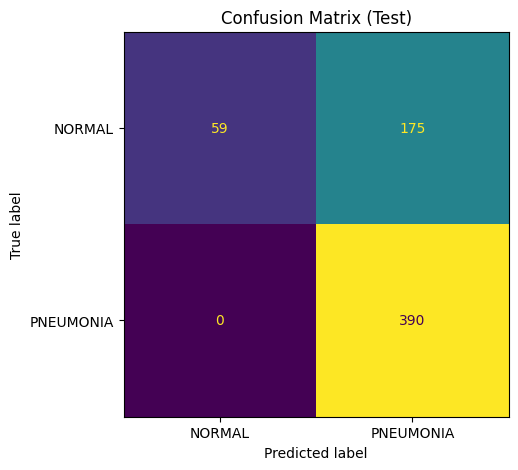

In [11]:

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
fig_cm, ax_cm = plt.subplots(figsize=(5,5))
disp.plot(ax=ax_cm, values_format='d', colorbar=False)
ax_cm.set_title("Confusion Matrix (Test)")
plt.show()


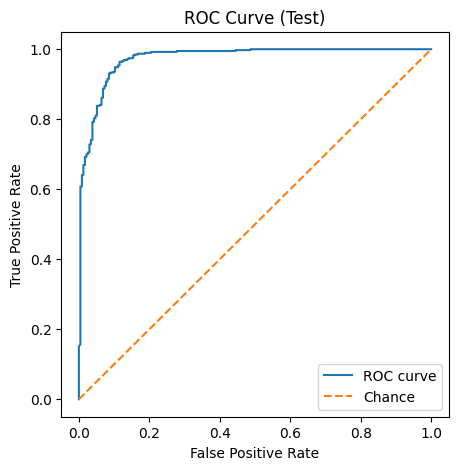

In [12]:

# ROC Curve (binary only)
if len(CLASSES) == 2:
    pos_index = 1
    try:
        fpr, tpr, _ = roc_curve(all_labels, all_probs[:, pos_index])
        fig_roc, ax_roc = plt.subplots(figsize=(5,5))
        ax_roc.plot(fpr, tpr, label="ROC curve")
        ax_roc.plot([0,1],[0,1],'--', label="Chance")
        ax_roc.set_xlabel("False Positive Rate")
        ax_roc.set_ylabel("True Positive Rate")
        ax_roc.set_title("ROC Curve (Test)")
        ax_roc.legend()
        plt.show()
    except Exception as e:
        print("Could not compute ROC curve:", e)
else:
    print("ROC curve is defined for binary classification; skipped.")


## 8) Inference Helper

In [13]:

from PIL import Image

def predict_image(path):
    img = Image.open(path).convert("L")  # grayscale
    img = eval_tfms(img)                 # same eval transforms
    img = img.unsqueeze(0).to(device)
    vit.eval()
    with torch.no_grad():
        logits = vit(img)
        probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
    pred_idx = int(probs.argmax())
    return CLASSES[pred_idx], probs

# Example usage:
# pred, probs = predict_image("/path/to/image.jpeg")
# print(pred, probs)



## 9) Notes linking to the ViT paper

- **Patch size 16×16** (ViT‑B/16) and **ImageNet pretraining** are consistent with Dosovitskiy et al. (2020).  
- We fine-tune the entire network (can also try a warmup with frozen backbone).  
- Input normalization uses ImageNet statistics to match pretraining.  
- You may extend experiments by varying patch size (e.g., `vit_b_32`) or data augmentation strength and compare results.


## 10) Save artifacts & configuration

In [14]:

import json
results = {
    "classes": CLASSES,
    "test_accuracy": float(acc),
    "best_val_acc": float(best_val_acc),
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "img_size": IMG_SIZE,
    "lr": LR,
    "weight_decay": WEIGHT_DECAY
}
with open("run_summary_vit.json", "w") as f:
    json.dump(results, f, indent=2)

print("Saved:", "vit_chest_xray_best.pt", "run_summary_vit.json")


Saved: vit_chest_xray_best.pt run_summary_vit.json
